In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split

from speedtest.utils.visualization import plot_comparison_histogram
from speedtest.utils.transform import OutlierRemover

In [4]:
# Reduce default figure size
plt.rcParams['figure.figsize'] = (4, 3)

In [5]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [6]:
cfg = OmegaConf.load('../../speedtest/conf/config.yaml')

## Load dataset

In [7]:
INPUTS = ['download_mbit', 'upload_mbit', 'time_utc']
TARGET = 'cat_technology'

In [8]:
df = pd.read_csv('../../data/processed/netztest-opendata-processed.csv')
df = df[INPUTS + [TARGET]]

In [9]:
df.sample(5)

,download_mbit,upload_mbit,time_utc,cat_technology
12379,2.791,16.715,2023-08-30 03:34:33,4G
1110,9.117,1.810,2023-08-21 06:21:29,3G
31489,234.228,100.588,2023-09-14 18:11:45,5G
33242,100.603,10.556,2023-09-15 15:14:03,4G
35172,6.948,8.938,2023-09-17 10:50:57,3G


## Train-test split

In [43]:
df_features = df.copy()

## Preprocessing

<img src="image.png" alt="" width="800"/>

### download_mbits_clean

#### Clip outliers

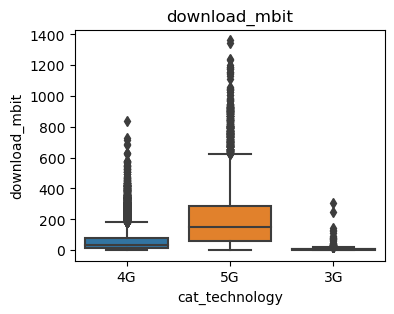

In [46]:
sns.boxplot(x='cat_technology', y='download_mbit', data=df)
plt.title('download_mbit')
plt.show()

In [47]:
maxvalue = df['download_mbit'].quantile(.99)
maxvalue

594.8073999999996

In [48]:
def clip_outliers(column: pd.Series, quantile: float = .99) -> pd.Series:
    column = column.copy()
    maxvalue = column.quantile(quantile)
    column.loc[column > maxvalue] = maxvalue

    return column

df_features['download_mbit_clean'] = clip_outliers(df['download_mbit'])

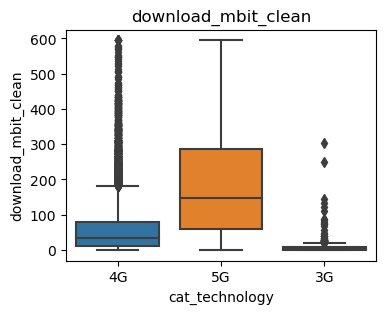

In [49]:
sns.boxplot(x='cat_technology', y='download_mbit_clean', data=df_features)
plt.title('download_mbit_clean')
plt.show()

#### z-Score scaling

In [41]:
X_train['download_mbit_clean'] = (X_train['download_mbit_clean'] - X_train['download_mbit_clean'].mean()) / X_train['download_mbit_clean'].std()

<Axes: >

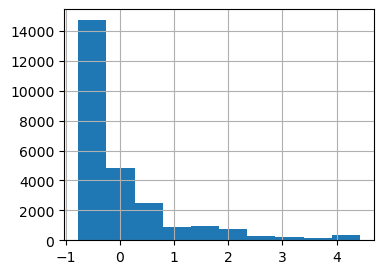

In [42]:
X_train['download_mbit_clean'].hist()